# Predicting Wine Ratings

In [1]:
#import packages
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wr = pd.read_csv('Data Sets/winemag-data-130k-v2.csv')

### Data Overview

In [3]:
#print(wr.info())

In [4]:
#print(wr.shape)

### Province is a more precise location than country and has more unique values to work with. We will drop country in favor of province. We will also drop the ID column. 

In [5]:
#print(wr.isnull().sum())
print('\nConfirming all 63 null values in country are also null values in province: {}.'.format(len(wr[(wr.country.isnull()) & (wr.country.isnull())])))
print('\nNumber of unique countries: {}.'.format(wr.country.nunique()))
print('Number of unique provinces: {}.'.format(wr.province.nunique()))


Confirming all 63 null values in country are also null values in province: 63.

Number of unique countries: 43.
Number of unique provinces: 425.


In [6]:
#Drop column 0. Column 0 is just a copy of the index.
#Drop where country and province is NULL
wr = wr.drop(columns = ['Unnamed: 0', 'country'])
wr = wr[~wr.province.isnull()]

In [7]:
twit = wr.groupby(['taster_name', 'taster_twitter_handle']).size().reset_index()
#print(twit)

### Each taster name has a one to one relationship with taster twitter handles so we can drop the twitter handle column. In other words, each taster is writing reviews under one and only one twitter account. 

In [8]:
wr = wr.drop(columns = ['taster_twitter_handle'])

### String values can be marked as other if Null value is provided. 

In [9]:
#print('Null Count')
#print(wr.isnull().sum())
#print('\nUnique Values Count')
#print(wr.nunique())

### Designation is the specific vineyard within the winery that the wine was made from. Although designation includes many null values, we can create a more specifc variable from winery + designation. Region_1 is the specific area within a province where the wine was made. Region_2 is the specific region within Region_1 where the wine was made. Region 2 has many null values and only 17 unique values so we can drop this column. Becuase Region_1 has 1229 unique values that can prove useful in determining points, we can combine province and region_1 to create a more specific variable with null values being 'Other'. We will fill in null values for taster name as 'Other' as well.

In [10]:
wr.designation = wr.designation.fillna(value = 'Other')
wr.region_1 = wr.region_1.fillna(value = 'Other')
wr.taster_name = wr.taster_name.fillna(value = 'Other')
wr = wr.drop(columns = ['region_2'])

### Let's create a function that we will be using to evaluate the significance of ratios in our categorical variables. This will come in handy when trying to determine the relationship between a categorical variable and our target variable which is also categorical. 

In [11]:
def plot_ratios(x, y, z):
    global ct
    ct = pd.crosstab(x, y, margins = True)
    ct = ct.div(ct.All, axis = 0)
    ct = ct.drop(columns = ['All'])
    ct = ct[:-1]
    mct = pd.melt(ct, id_vars = [z], value_vars = [0, 1])
    plt.figure(figsize = (15,8))
    sns.boxplot(mct.good_score, mct.value)

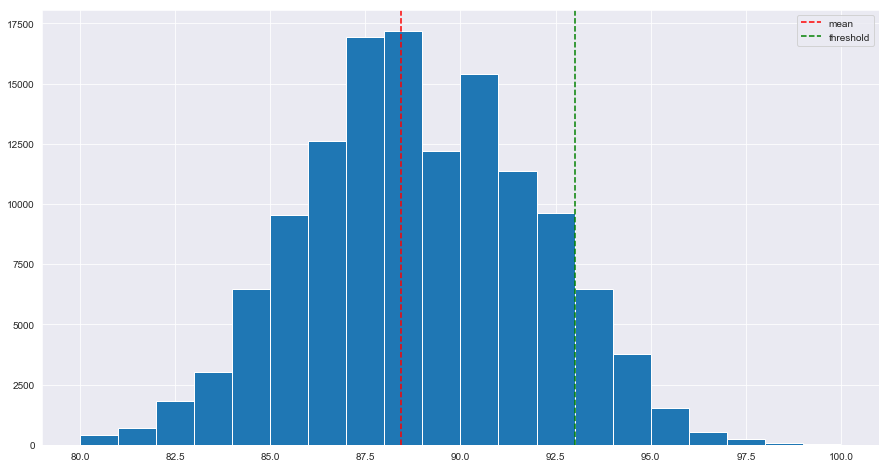

We will use the 95th percentile to represent a good score: 93


In [12]:
ind = round(len(wr.points) * .95)
temp = wr.points.sort_values()
thresh = np.array(temp).reshape(-1)[ind]

sns.set_style('darkgrid')

plt.figure(figsize = (15,8))
plt.hist(wr.points, bins = 20)
plt.axvline(np.mean(wr.points), linestyle = '--', color = 'red', label = 'mean')
plt.axvline(thresh, linestyle = '--', color = 'green', label = 'threshold')
plt.legend()
plt.show()

print('We will use the 95th percentile to represent a good score: {}'.format(thresh))

In [13]:
wr['good_score'] = np.where(wr.points >= 93, 1, 0)

### We will be using the median of the province the wine originates from to fill in Null values of price.

In [14]:
#wr.price = wr.price.fillna(value = 0)
#wr.province = wr.province.fillna(value = 'unknown')
temp = wr[['province', 'price']]
prov = temp.groupby(['province']).agg(np.median)
prov = prov.reset_index()
wr = wr.reset_index()
wr = wr.drop(columns = 'index')

In [15]:
for x in range(0,len(wr.price)):
    if math.isnan(wr.price[x]):
        if prov.province.isin([str(wr.province[x])]).any():
            for y in range(0,len(prov.province)):
                if prov.province[y] == wr.province[x]:
                    wr.price[x] = prov.price[y]
                else: 
                    pass
        else:
            pass
    else:
        pass

c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### We can drop the remaining 3 null values in price and variety that did not have a province to impute a price from.

In [16]:
wr = wr.dropna(subset = ['price', 'variety'])

In [17]:
print(wr.isnull().sum())

description    0
designation    0
points         0
price          0
province       0
region_1       0
taster_name    0
title          0
variety        0
winery         0
good_score     0
dtype: int64


### Our dataset is looking a lot better. Let's do some EDA. First, we are going to combine the province and region columns to get a more accurate location of wine.

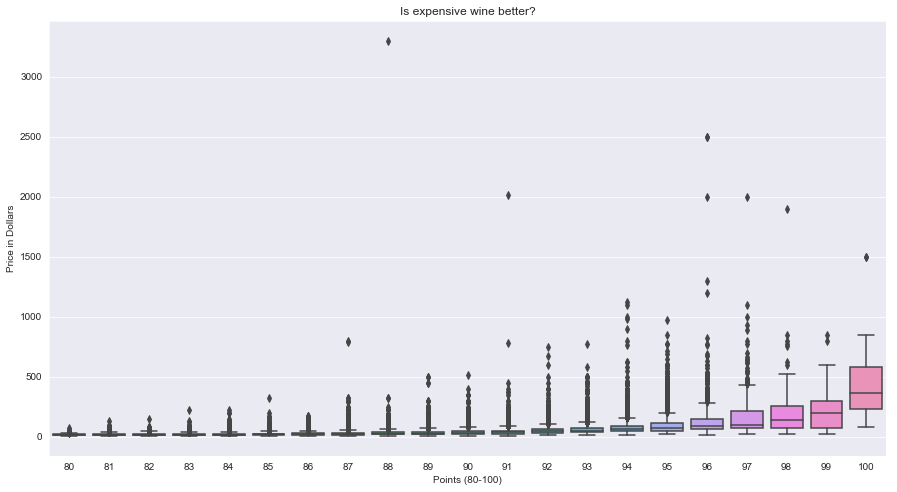

In [18]:
plt.figure(figsize = (15,8))
sns.boxplot(wr.points, wr.price)
plt.title('Is expensive wine better?')
plt.xlabel('Points (80-100)')
plt.ylabel('Price in Dollars')
plt.show()

In [19]:
wr['province_region'] = wr.province + wr.region_1
wr = wr.drop(columns = ['province', 'region_1'])

c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


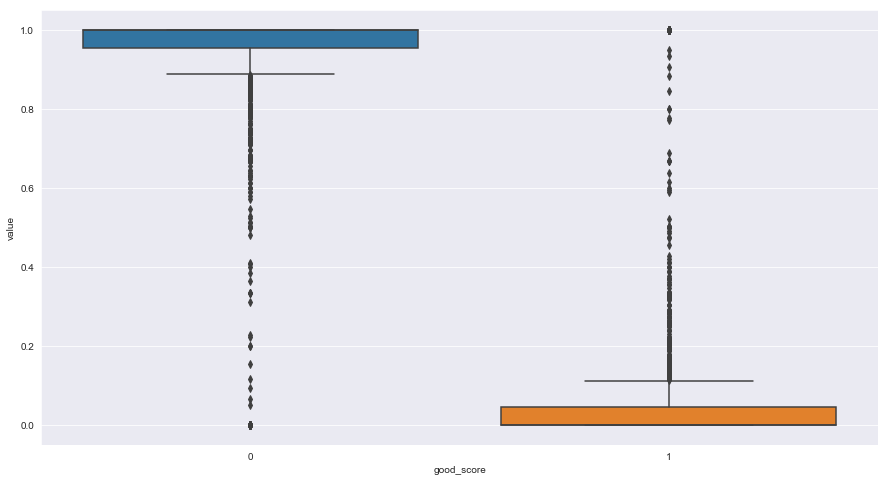

In [20]:
plot_ratios(wr.province_region, wr.good_score, 'province_region')

### Using our plot_ratios function, we can find the ratio of good wine to bad wine per province/region which will help us reduce some dimensionality of categorical variables. Our data set would contain too much noise if we used dummy variables for each province/region combination. 

good_score                                     0         1
province_region_2                                         
Aconcagua ValleyOther                   0.974138  0.025862
AhrOther                                0.777778  0.222222
AlentejanoOther                         0.942369  0.057631
AlentejoOther                           0.879121  0.120879
AlsaceAlsace                            0.812298  0.187702
AlsaceCrémant d'Alsace                  0.956679  0.043321
AmericaOther                            0.989474  0.010526
AndaluciaJerez                          0.846774  0.153226
AndaluciaMontilla-Moriles               0.777778  0.222222
AndaluciaMálaga                         0.968750  0.031250
Australia OtherSouth Eastern Australia  0.995169  0.004831
AustriaOther                            0.961538  0.038462
BadenOther                              0.919355  0.080645
BairradaOther                           0.946108  0.053892
BeaujolaisChénas                        0.894737  0.1052

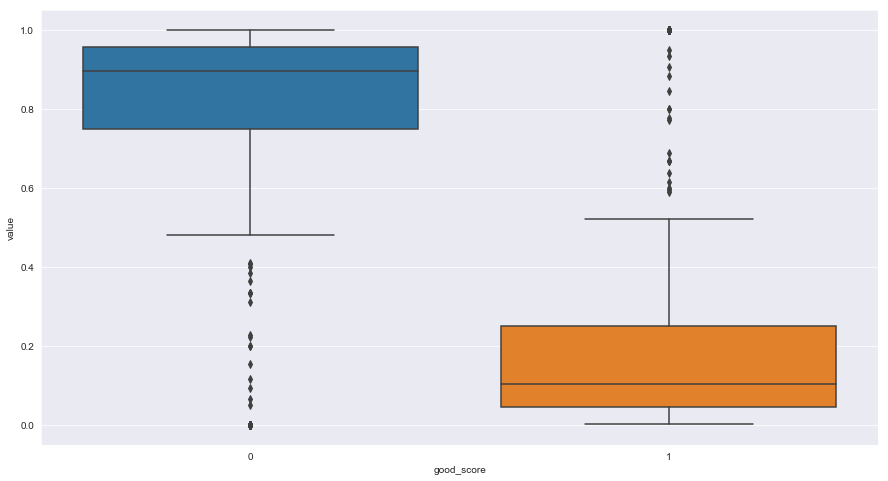

In [21]:
low_prov_reg = []
for x in range(0,len(ct[0])):
    if ct[0][x] == 1:
        low_prov_reg.append(ct.index[x])
    else: 
        pass
wr['very_low_province_region'] = np.where(wr.province_region.isin(low_prov_reg), 1, 0)

#Let's regraph our countries without countries that only have bad reviews. 
wr['province_region_2'] = np.where(wr.very_low_province_region == 1, 'Other', wr.province_region)
df_temp = wr[['province_region_2', 'good_score']]
df_temp = df_temp[df_temp['province_region_2'] != 'Other']

plot_ratios(df_temp.province_region_2, df_temp.good_score, 'low_prov_reg')
print(ct)

### We will split the province_region column into 6 separate binary classes. Very low will contain ratio percentages of 0. Low will contain percentages of good wine from 1 to 25 percent. Mid will contain wine percentages from 26 - 50, high will contain percentages from 51 - 75, and very high will contain percentages from 76 - 99. 100 will not need a separate column because we can deduce that if the variable is now low, mid, or high, the variable must be 100.

In [22]:
low_province_region = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.25) & (ct[1][x] > 0):
        low_province_region.append(ct.index[x])
    else: 
        pass
wr['low_province_region'] = np.where(wr.province_region.isin(low_province_region), 1, 0)

mid_province_region = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.5) & (ct[1][x] > 0.25):
        mid_province_region.append(ct.index[x])
    else: 
        pass
wr['mid_province_region'] = np.where(wr.province_region.isin(mid_province_region), 1, 0)

high_province_region = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.75) & (ct[1][x] > 0.5):
        high_province_region.append(ct.index[x])
    else: 
        pass
wr['high_province_region'] = np.where(wr.province_region.isin(high_province_region), 1, 0)

very_high_province_region = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 1) & (ct[1][x] > 0.75):
        high_province_region.append(ct.index[x])
    else: 
        pass
wr['very_high_province_region'] = np.where(wr.province_region.isin(very_high_province_region), 1, 0)

### Let's combine our winery and designation columns.

In [23]:
wr['winery_designation'] = wr.winery + wr.designation

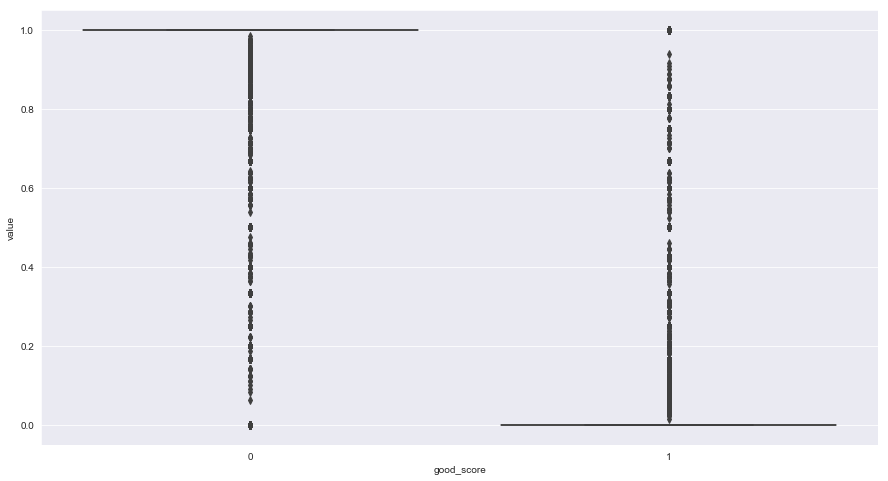

In [24]:
plot_ratios(wr.winery_designation, wr.good_score, 'winery_designation')

good_score                                                 0         1
winery_designation_2                                                  
12C WinesBeckstoffer Vineyard Georges III           0.000000  1.000000
12C WinesBeckstoffer Vineyard Georges III G3        0.000000  1.000000
12C WinesG3 Beckstoffer Vineyard Georges III        0.000000  1.000000
1912 WinemakersEncosta do Bocho Grand Reserva       0.000000  1.000000
1912 WinemakersPiorro Grande Reserva                0.000000  1.000000
21 GramsOther                                       0.500000  0.500000
32 WindsHirsch Vineyard                             0.000000  1.000000
6 NorthFlagstone                                    0.666667  0.333333
A.A. Badenhorst Family WinesOther                   0.600000  0.400000
A.R. Lenoble Gentilhomme Blanc de Blancs Grand ...  0.000000  1.000000
A.R. Lenoble Grand Cru Blanc de Blancs Chouilly...  0.750000  0.250000
AaronTrespasser                                     0.000000  1.000000
Abacel

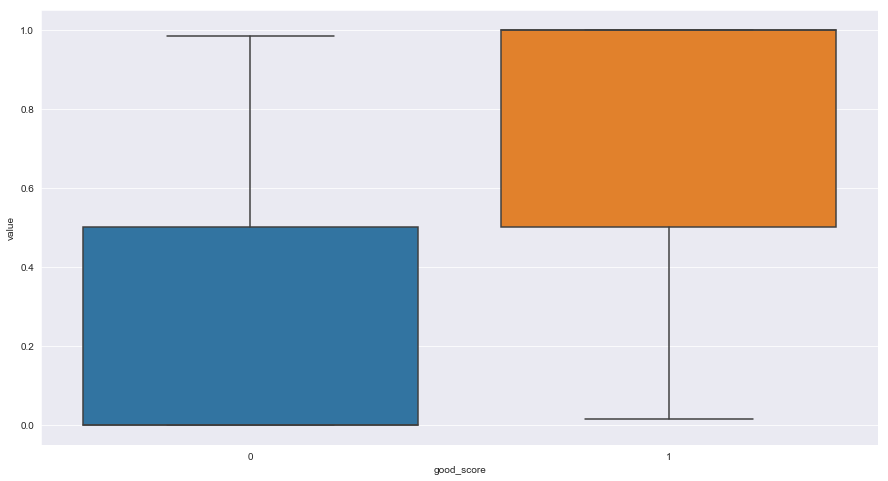

In [25]:
low_win_des = []
for x in range(0,len(ct[0])):
    if ct[0][x] == 1:
        low_win_des.append(ct.index[x])
    else: 
        pass
wr['very_low_wine_designation'] = np.where(wr.winery_designation.isin(low_win_des), 1, 0)

#Let's regraph our countries without countries that only have bad reviews. 
wr['winery_designation_2'] = np.where(wr.very_low_wine_designation == 1, 'Other', wr.winery_designation)
df_temp = wr[['winery_designation_2', 'good_score']]
df_temp = df_temp[df_temp['winery_designation_2'] != 'Other']

plot_ratios(df_temp.winery_designation_2, df_temp.good_score, 'winery_designation_2')
print(ct)

In [26]:
low_winery_designation = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.25) & (ct[1][x] > 0):
        low_winery_designation.append(ct.index[x])
    else: 
        pass
wr['low_winery_designation'] = np.where(wr.winery_designation.isin(low_winery_designation), 1, 0)

mid_winery_designation = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.5) & (ct[1][x] > 0.25):
        mid_winery_designation.append(ct.index[x])
    else: 
        pass
wr['mid_winery_designation'] = np.where(wr.winery_designation.isin(mid_winery_designation), 1, 0)

high_winery_designation = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.75) & (ct[1][x] > 0.5):
        high_winery_designation.append(ct.index[x])
    else: 
        pass
wr['high_winery_designation'] = np.where(wr.winery_designation.isin(high_winery_designation), 1, 0)

very_high_winery_designation = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 1) & (ct[1][x] > 0.75):
        very_high_winery_designation.append(ct.index[x])
    else: 
        pass
wr['very_high_winery_designation'] = np.where(wr.winery_designation.isin(very_high_winery_designation), 1, 0)

### We will do the same process for variety.

good_score                      0         1
variety                                    
Abouriou                 1.000000  0.000000
Agiorgitiko              1.000000  0.000000
Aglianico                0.880223  0.119777
Aidani                   1.000000  0.000000
Airen                    1.000000  0.000000
Albana                   0.826087  0.173913
Albanello                1.000000  0.000000
Albariño                 0.991614  0.008386
Albarossa                1.000000  0.000000
Aleatico                 1.000000  0.000000
Alfrocheiro              0.937500  0.062500
Alicante                 1.000000  0.000000
Alicante Bouschet        0.900000  0.100000
Aligoté                  1.000000  0.000000
Alsace white blend       0.705882  0.294118
Altesse                  1.000000  0.000000
Alvarelhão               1.000000  0.000000
Alvarinho                0.970803  0.029197
Alvarinho-Chardonnay     1.000000  0.000000
Ansonica                 1.000000  0.000000
Antão Vaz                1.00000

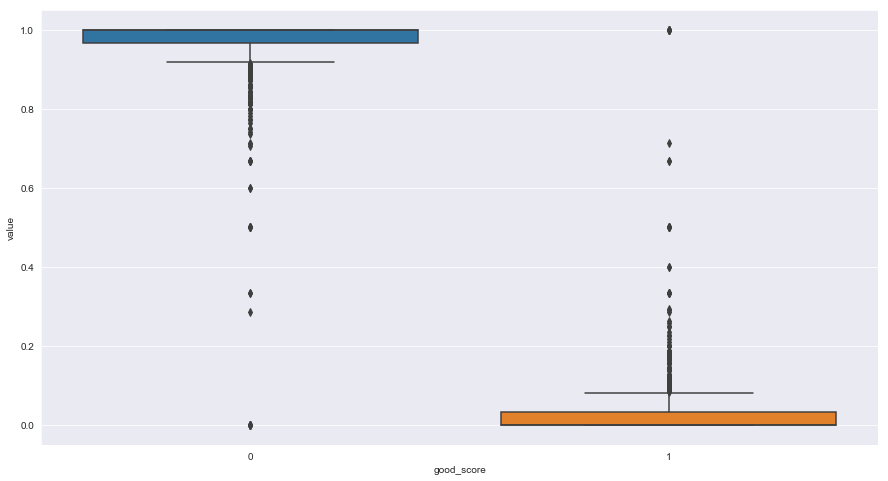

In [27]:
plot_ratios(wr.variety, wr.good_score, 'variety')
print(ct)

good_score                                0         1
variety2                                             
Aglianico                          0.880223  0.119777
Albana                             0.826087  0.173913
Albariño                           0.991614  0.008386
Alfrocheiro                        0.937500  0.062500
Alicante Bouschet                  0.900000  0.100000
Alsace white blend                 0.705882  0.294118
Alvarinho                          0.970803  0.029197
Assyrtiko                          0.941176  0.058824
Austrian Red Blend                 0.887097  0.112903
Austrian white blend               0.797468  0.202532
Baga                               0.862069  0.137931
Barbera                            0.990291  0.009709
Blauburgunder                      0.000000  1.000000
Blaufränkisch                      0.827586  0.172414
Bordeaux-style Red Blend           0.857701  0.142299
Bordeaux-style White Blend         0.840525  0.159475
Braucol                     

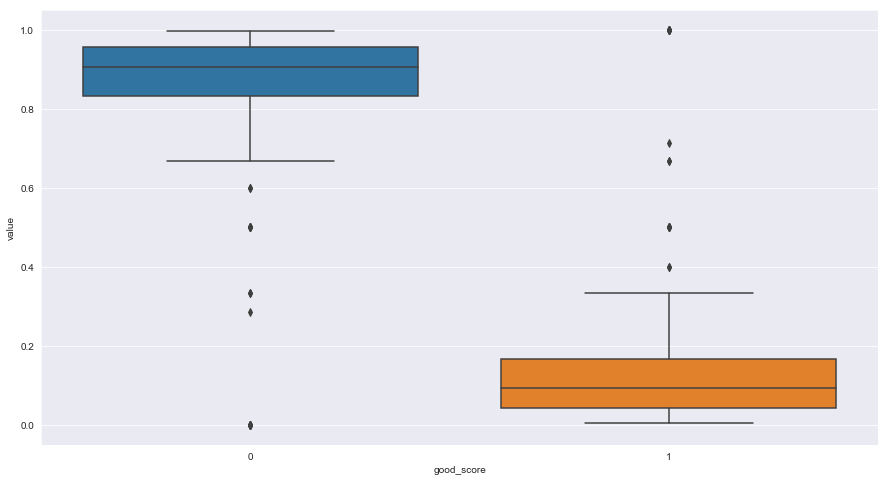

In [28]:
low_var = []
for x in range(0,len(ct[0])):
    if ct[0][x] == 1:
        low_var.append(ct.index[x])
    else: 
        pass
wr['very_low_variety'] = np.where(wr.variety.isin(low_var), 1, 0)

#Let's regraph our countries without countries that only have bad reviews. 
wr['variety2'] = np.where(wr.very_low_variety == 1, 'Other', wr.variety)
df_temp = wr[['variety2', 'good_score']]
df_temp = df_temp[df_temp['variety2'] != 'Other']

plot_ratios(df_temp.variety2, df_temp.good_score, 'variety2')
print(ct)

In [29]:
low_variety = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.25) & (ct[1][x] > 0):
        low_variety.append(ct.index[x])
    else: 
        pass
wr['low_variety'] = np.where(wr.variety.isin(low_variety), 1, 0)

mid_variety = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.5) & (ct[1][x] > 0.25):
        mid_variety.append(ct.index[x])
    else: 
        pass
wr['mid_variety'] = np.where(wr.variety.isin(mid_variety), 1, 0)

high_variety = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 0.75) & (ct[1][x] > 0.5):
        high_variety.append(ct.index[x])
    else: 
        pass
wr['high_variety'] = np.where(wr.variety.isin(high_variety), 1, 0)

very_high_variety = []
for x in range(0,len(ct[0])):
    if (ct[1][x] <= 1) & (ct[1][x] > 0.75):
        very_high_variety.append(ct.index[x])
    else: 
        pass
wr['very_high_variety'] = np.where(wr.variety.isin(very_high_variety), 1, 0)

### Let's investigate the spread of data for wine tasters. 

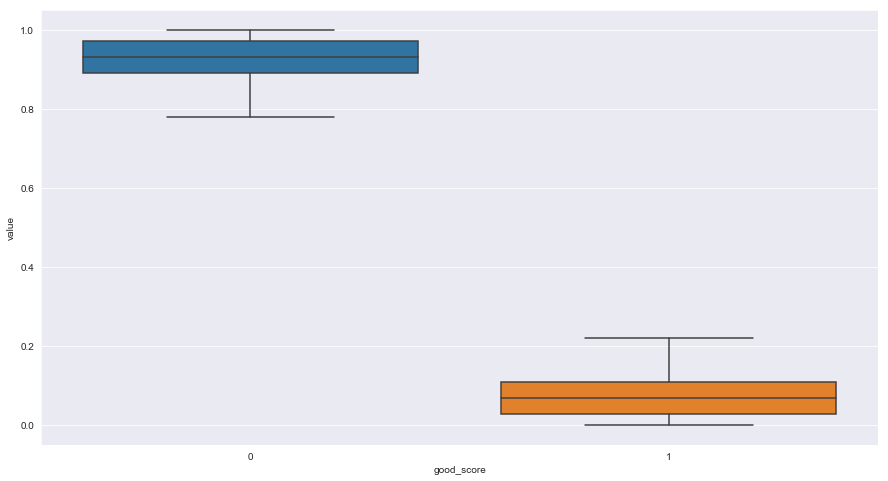

In [30]:
plot_ratios(wr.taster_name, wr.good_score, 'taster_name')

In [31]:
#print(ct)

In [32]:
wr3 = pd.get_dummies(wr.taster_name)
wr = pd.concat([wr, wr3], axis = 1)
wr = wr.drop(columns = ['taster_name'])

In [33]:
print(wr.columns)

Index(['description', 'designation', 'points', 'price', 'title', 'variety',
       'winery', 'good_score', 'province_region', 'very_low_province_region',
       'province_region_2', 'low_province_region', 'mid_province_region',
       'high_province_region', 'very_high_province_region',
       'winery_designation', 'very_low_wine_designation',
       'winery_designation_2', 'low_winery_designation',
       'mid_winery_designation', 'high_winery_designation',
       'very_high_winery_designation', 'very_low_variety', 'variety2',
       'low_variety', 'mid_variety', 'high_variety', 'very_high_variety',
       'Alexander Peartree', 'Anna Lee C. Iijima', 'Anne Krebiehl MW',
       'Carrie Dykes', 'Christina Pickard', 'Fiona Adams', 'Jeff Jenssen',
       'Jim Gordon', 'Joe Czerwinski', 'Kerin O’Keefe', 'Lauren Buzzeo',
       'Matt Kettmann', 'Michael Schachner', 'Mike DeSimone', 'Other',
       'Paul Gregutt', 'Roger Voss', 'Sean P. Sullivan', 'Susan Kostrzewa',
       'Virginie Boone'],


### Let's run a quick model to see how our variables look.

In [34]:
wr2 = wr.drop(columns = ['description', 
                         'designation', 
                         'points',
                         'title',
                         'variety', 
                         'winery',
                         'province_region',
                         'province_region_2',
                         'winery_designation',
                         'winery_designation_2',
                         'variety2'])

In [35]:
print(wr2.columns)

Index(['price', 'good_score', 'very_low_province_region',
       'low_province_region', 'mid_province_region', 'high_province_region',
       'very_high_province_region', 'very_low_wine_designation',
       'low_winery_designation', 'mid_winery_designation',
       'high_winery_designation', 'very_high_winery_designation',
       'very_low_variety', 'low_variety', 'mid_variety', 'high_variety',
       'very_high_variety', 'Alexander Peartree', 'Anna Lee C. Iijima',
       'Anne Krebiehl MW', 'Carrie Dykes', 'Christina Pickard', 'Fiona Adams',
       'Jeff Jenssen', 'Jim Gordon', 'Joe Czerwinski', 'Kerin O’Keefe',
       'Lauren Buzzeo', 'Matt Kettmann', 'Michael Schachner', 'Mike DeSimone',
       'Other', 'Paul Gregutt', 'Roger Voss', 'Sean P. Sullivan',
       'Susan Kostrzewa', 'Virginie Boone'],
      dtype='object')


In [36]:
#Drop any features with all 0's in the column. 
wr2 = wr2.drop(columns = ['very_high_province_region'])

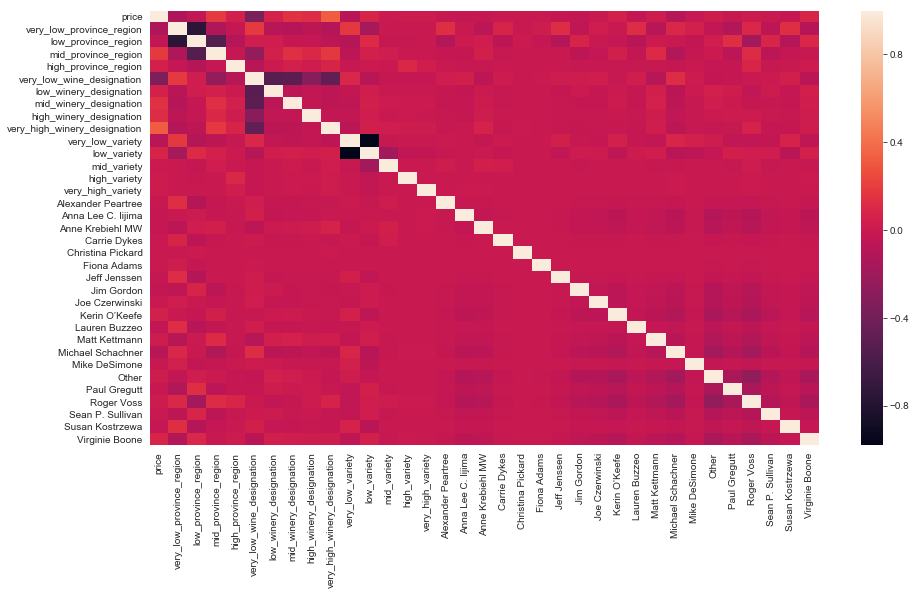

In [37]:
correl = wr2.loc[:, ~wr2.columns.isin(['good_score'])]
plt.figure(figsize = (15,8))
sns.heatmap(correl.corr())

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
X = wr2.loc[:, ~wr2.columns.isin(['good_score'])]
y = wr2.good_score

cvs = cross_val_score(lr, X, y, cv = 10)
print('Logistic Regression cross value scores: {}'.format(cvs))

print('Mean of scores is {}.'.format(np.mean(cvs)))
print('Std Dev of scores is {}.'.format(np.std(cvs)))

c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\chase\appdata\local\programs\python\python37\lib\si

Logistic Regression cross value scores: [0.96005234 0.9592795  0.95966438 0.96212471 0.95673595 0.96243264
 0.96166282 0.95950731 0.96150885 0.95981524]
Mean of scores is 0.960278375299738.
Std Dev of scores is 0.0016206233128544594.


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

lr2 = LogisticRegression()
X2 = wr2.loc[:, ~wr2.columns.isin(['good_score'])]
y2 = wr2.good_score

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2)

print('With 20% holdout: {}'.format(lr2.fit(X_train, y_train).score(X_test, y_test)))
print('Without holdout group: {}'.format(lr2.fit(X2, y2).score(X2,y2)))

y_pred = lr2.predict(X_test)

residuals = y_pred - y_test

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


With 20% holdout: 0.9605480928370732


c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Without holdout group: 0.96045541322823
[[23204   296]
 [  719  1762]]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     23500
           1       0.86      0.71      0.78      2481

   micro avg       0.96      0.96      0.96     25981
   macro avg       0.91      0.85      0.88     25981
weighted avg       0.96      0.96      0.96     25981



In [57]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

Xgbc = wr2.loc[:, ~wr2.columns.isin(['good_score'])]
ygbc = wr2.good_score

gbc = GradientBoostingClassifier(n_estimators = 100, max_depth = 2, loss = 'deviance')

x_train, x_test, y_train, y_test = train_test_split(Xgbc, ygbc, test_size = 0.2)

print('With 20 percent holdout: {}.'.format(gbc.fit(x_train, y_train).score(x_test, y_test)))
print('Without holdout group: {}.'.format(gbc.fit(Xgbc, ygbc).score(Xgbc, ygbc)))

y_pred2 = gbc.predict(x_test)

acc2 = accuracy_score(y_test, y_pred2)
print('Accuracy is: {}.'.format(acc2))

y_pred = gbc.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

With 20 percent holdout: 0.9602786651783995.
Without holdout group: 0.9604015272816849.
Accuracy is: 0.9604326238404989.
[[23216   241]
 [  787  1737]]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     23457
           1       0.88      0.69      0.77      2524

   micro avg       0.96      0.96      0.96     25981
   macro avg       0.92      0.84      0.87     25981
weighted avg       0.96      0.96      0.96     25981



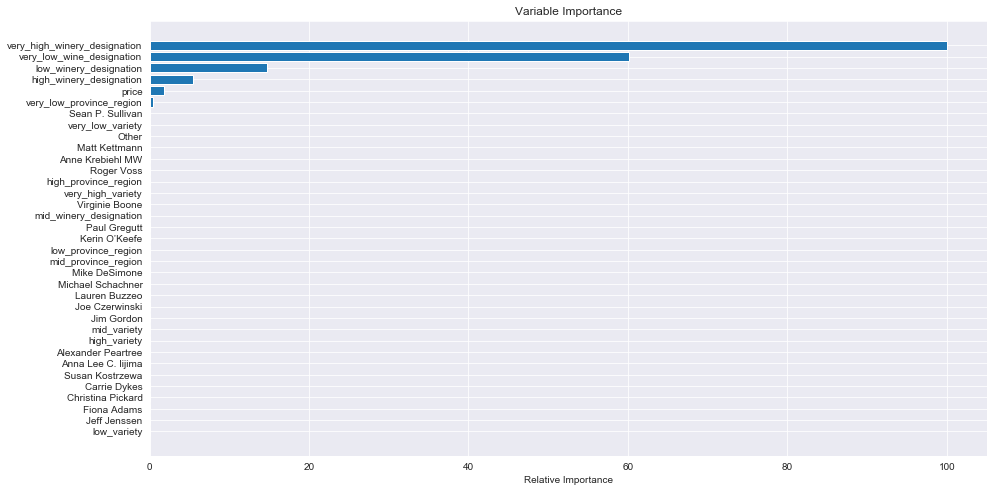

In [41]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (15,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xgbc.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [42]:
fi = pd.DataFrame()

fi['col'] = Xgbc.columns[sorted_idx]
fi['imp'] = np.sort(feature_importance)

print(list(fi.col[fi.imp == 0]))

['low_variety', 'Jeff Jenssen', 'Fiona Adams', 'Christina Pickard', 'Carrie Dykes', 'Susan Kostrzewa', 'Anna Lee C. Iijima', 'Alexander Peartree', 'high_variety', 'mid_variety', 'Jim Gordon', 'Joe Czerwinski', 'Lauren Buzzeo', 'Michael Schachner', 'Mike DeSimone', 'mid_province_region', 'low_province_region', 'Kerin O’Keefe']


In [43]:
wr3 = wr2.drop(columns = list(fi.col[fi.imp == 0]))

In [58]:
Xgbc2 = wr3.loc[:, ~wr3.columns.isin(['good_score'])]
ygbc2 = wr3.good_score

gbc = GradientBoostingClassifier(n_estimators = 100, max_depth = 2, loss = 'deviance')

x_train, x_test, y_train, y_test = train_test_split(Xgbc2, ygbc2, test_size = 0.2)

print('With 20 percent holdout: {}.'.format(gbc.fit(x_train, y_train).score(x_test, y_test)))
print('Without holdout group: {}.'.format(gbc.fit(Xgbc2, ygbc2).score(Xgbc2, ygbc2)))

y_pred3 = gbc.predict(x_test)

acc3 = accuracy_score(y_test, y_pred3)
print('Accuracy is: {}.'.format(acc3))

y_pred = gbc.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

With 20 percent holdout: 0.9598167891921019.
Without holdout group: 0.9604015272816849.
Accuracy is: 0.9604711135060237.
[[23198   239]
 [  788  1756]]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     23437
           1       0.88      0.69      0.77      2544

   micro avg       0.96      0.96      0.96     25981
   macro avg       0.92      0.84      0.88     25981
weighted avg       0.96      0.96      0.96     25981



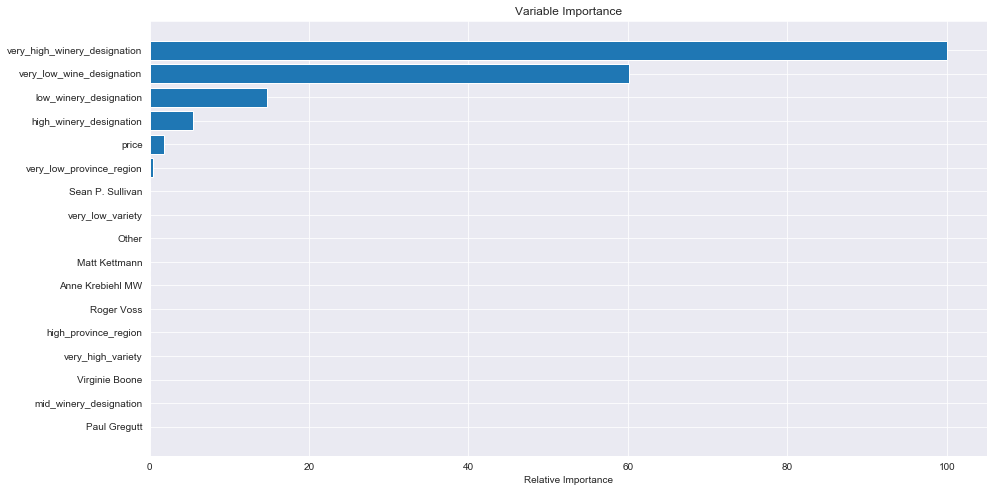

In [45]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (15,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xgbc2.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [46]:
fi = pd.DataFrame()

fi['col'] = Xgbc2.columns[sorted_idx]
fi['imp'] = np.sort(feature_importance)

print(list(fi.col[fi.imp == 0]))

[]


In [72]:
from sklearn.model_selection import GridSearchCV

est_range = range(50,200,50)
dep_range = range(2,6)

param_grid = dict(n_estimators = est_range,
                  max_depth = dep_range,)

gbc = GradientBoostingClassifier(loss = 'deviance')
Xgbc3 = wr3.loc[:, ~wr3.columns.isin(['good_score'])]
ygbc3 = wr3.good_score

grid = GridSearchCV(gbc, param_grid, cv = 5, scoring = 'accuracy')

grid.fit(Xgbc3, ygbc3)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(50, 200, 50), 'max_depth': range(2, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [73]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9605400911442296
{'max_depth': 3, 'n_estimators': 150}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [47]:
from sklearn.svm import SVC

svc = SVC()
Xsvc = wr2.loc[:, ~wr2.columns.isin(['good_score'])]
ysvc = wr2.good_score

cvs = cross_val_score(svc, Xsvc, ysvc, cv = 3)
print('Support Vector Classification cross value scores: {}'.format(cvs))

print('Mean of scores is {}.'.format(np.mean(cvs)))
print('Std Dev of scores is {}.'.format(np.std(cvs)))

c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\chase\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

Support Vector Classification cross value scores: [0.95937832 0.95956213 0.95787626]
Mean of scores is 0.9589389053499943.
Std Dev of scores is 0.0007551405759199323.


In [48]:
print(wr2.columns)

Index(['price', 'good_score', 'very_low_province_region',
       'low_province_region', 'mid_province_region', 'high_province_region',
       'very_low_wine_designation', 'low_winery_designation',
       'mid_winery_designation', 'high_winery_designation',
       'very_high_winery_designation', 'very_low_variety', 'low_variety',
       'mid_variety', 'high_variety', 'very_high_variety',
       'Alexander Peartree', 'Anna Lee C. Iijima', 'Anne Krebiehl MW',
       'Carrie Dykes', 'Christina Pickard', 'Fiona Adams', 'Jeff Jenssen',
       'Jim Gordon', 'Joe Czerwinski', 'Kerin O’Keefe', 'Lauren Buzzeo',
       'Matt Kettmann', 'Michael Schachner', 'Mike DeSimone', 'Other',
       'Paul Gregutt', 'Roger Voss', 'Sean P. Sullivan', 'Susan Kostrzewa',
       'Virginie Boone'],
      dtype='object')


In [49]:
print(wr2.good_score.value_counts())
print('\nGood Wines {}.'.format(12663/(117241+12663)))
print('Bad Wines {}.'.format(117241/(117241+12663)))

0    117241
1     12663
Name: good_score, dtype: int64

Good Wines 0.09747967730016012.
Bad Wines 0.9025203226998398.


# MISC NOTES/ATTEMPTS

In [87]:
print(titles[0:100])

Chambers Rosewood Vineyards NV Rare Muscat (Rutherglen) Chambers Rosewood Vineyards NV Rare Muscadel


In [105]:
titles = (' ').join(wr.title[wr.good_score == 1])
word_count = {}
sp_titles = titles.split()

for word in sp_titles:
    if word in word_count:
        word_count[word] +=1
    else:
        word_count[word] = 1

from operator import itemgetter
from heapq import nlargest

print(nlargest(500, word_count.items(), itemgetter(1)))

[('Valley)', 2410), ('Vineyard', 2386), ('Pinot', 2027), ('Noir', 1914), ('2014', 1788), ('2013', 1768), ('2012', 1700), ('Red', 1315), ('Sauvignon', 1314), ('Cabernet', 1312), ('2010', 1158), ('2011', 1090), ('de', 1030), ('2009', 1003), ('Château', 979), ('Chardonnay', 906), ('Cru', 837), ('Domaine', 826), ('Riesling', 818), ('2007', 806), ('2015', 794), ('2008', 735), ('(Napa', 678), ('di', 658), ('Estate', 657), ('(Santa', 628), ('River', 609), ('2006', 590), ('(Russian', 584), ('Syrah', 573), ('Valley', 557), ('Reserve', 555), ('Grand', 505), ('Hills)', 478), ('(WA))', 465), ('(Sonoma', 452), ('La', 423), ('(Barolo)', 422), ('Clos', 409), ('(Alsace)', 406), ('Premier', 397), ('Brut', 396), ('Coast)', 380), ('2005', 370), ('(Champagne)', 353), ('Les', 345), ('Rita', 294), ('County)', 288), ('Riserva', 287), ('(Sta.', 280), ('(Columbia', 273), ('&', 268), ('Walla', 257), ('(Walla', 251), ('Barrel', 244), ('Cuvée', 242), ('Maria', 233), ('Quinta', 229), ('The', 229), ('Blanc', 229), 

In [113]:
wr['old'] = np.where(wr.title.str.contains('Old'), 1, 0)
wr['vintage'] = np.where(wr.title.str.contains('Vintage'), 1, 0)
wr['classico'] = np.where(wr.title.str.contains('Classico'), 1, 0)
wr['premier'] = np.where(wr.title.str.contains('Premier'), 1, 0)
wr['grand'] = np.where(wr.title.str.contains('Grand'), 1, 0)

In [114]:
print(wr['old'].value_counts())
print(wr['vintage'].value_counts())
print(wr['classico'].value_counts())
print(wr['premier'].value_counts())
print(wr['grand'].value_counts())

0    128784
1      1120
Name: old, dtype: int64
0    129355
1       549
Name: vintage, dtype: int64
0    127509
1      2395
Name: classico, dtype: int64
0    128500
1      1404
Name: premier, dtype: int64
0    127290
1      2614
Name: grand, dtype: int64
